# Calibrating the pre-trained via Input correction

Input correction model based on : $\quad \quad Y_{\text{final}} = f_{\text{pretrained}}(f_{\text{corrected}}(f_{\text{pretrained}}(X_{\text{input}}), X_{\text{input}}))$

In [ ]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.instantiate()

# Load the packages
using OrdinaryDiffEq, ComponentArrays, Flux, Plots, JLD2, BSON, Measures, Statistics, ProgressMeter, LinearAlgebra, Random, LaTeXStrings

Random.seed!(333) # report seed : 333 

# File paths
trained_model_file = joinpath(@__DIR__, "..", "trained_model.bson")
burgers_data_file  = joinpath(@__DIR__, "..", "burgers1d_periodic.jld2")
results_dir = "img"
mkpath(results_dir)   

# Training hyperparameters
n_epochs = 3000  # aprox 27 mins
batch_size = 40
learning_rate = 0.001

# Color palette
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

nothing

  Activating new project at `~/Desktop/Deltares/Final Report Code/Model-1/input_correction`


#### Setup

In [2]:
# Model configuration 
n_in = 1 # number of input channels (X)
n_out = 1 # number of output channels (Y)
n_hidden = 8 # number of hidden features in the model
n_filter = 3 # width of the convolutional filter

# Reuse circular padding helper
n_pad = n_filter ÷ 2
PadCircular(x) = pad_circular(x, (n_pad, n_pad, 0, 0, 0, 0))

# Reuse residual block definition
struct ResidualBlock
    f::Chain  
end

# Define how the ResidualBlock works
(m::ResidualBlock)(x) = x + m.f(x)

# Allow Flux to recognize ResidualBlock as a layer
Flux.@layer ResidualBlock

# Reuse unroll the model to get the output for the initial condition 
function unroll_pretrained(model, x0, n_steps)
    x = reshape(x0, size(x0, 1), size(x0, 2), 1) # ensure x0 is 3
    outputs = zeros(Float64, size(x0, 1), size(x0, 2), n_steps + 1)
    outputs[:, :, 1] .= x0 # store the initial condition
    # unroll the model for nstep
    for t in 1:n_steps
        x = model(x)
        outputs[:, :, t + 1] .= x
    end
    return outputs
end

unroll_pretrained (generic function with 1 method)

#### Burgers Simulation Data ####

In [3]:
# Load simulation data 
burgers_data = load(burgers_data_file)
burgers_times = burgers_data["times"]

# Extract dimensions 
n_times = length(burgers_data["solution"])
n_steps = n_times - 1
n_points = length(burgers_data["solution"][1])

# Allocate supervised learning arrays 
X = zeros(Float64, n_points, 1, n_steps)
Y = zeros(Float64, n_points, 1, n_steps)

# Define training pairs (X_t → Y_t)
for t in 1:n_steps
    X[:,:,t] .= Float64.(burgers_data["solution"][t]) # state at time t
    Y[:,:,t] .= Float64.(burgers_data["solution"][t+1]) # state at time t + 1
end

nothing

In [4]:
# Dataset split 
n_samples = size(X, 3)
n_val = 100 
n_train = 500

# Ensure the requested split is valid
if n_train + n_val > n_samples
    error("n_train + n_val must be less than or equal to the number of samples: $n_samples")
end

# Partition the dataset into training and validation sets
X_train = X[:, :, 1:n_train]
Y_train = Y[:, :, 1:n_train]

X_val = X[:, :, n_train + 1:n_train + n_val]
Y_val = Y[:, :, n_train + 1:n_train + n_val]

@show size(X_train), size(Y_train)
@show size(X_val), size(Y_val)

nothing

(size(X_train), size(Y_train)) = ((100, 1, 500), (100, 1, 500))
(size(X_val), size(Y_val)) = ((100, 1, 100), (100, 1, 100))


#### Trained Model Data ####

In [5]:
# Load the pretrained surrogate model from file
loaded = BSON.load(trained_model_file)

trained_model = loaded[:trained_model] 
trained_model = f64(trained_model)
trained_params = Flux.trainable(trained_model)

println("Surrogate trained model loaded. Summary: \n$(trained_model)")
println("Number of parameters in trained model: ", sum(length, Flux.trainable(trained_model)))


Surrogate trained model loaded. Summary: 
ResidualBlock(Chain(PadCircular, Conv((3,), 1 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 8, swish), PadCircular, Conv((3,), 8 => 1)))
Number of parameters in trained model: 8


#### Calibration Network 

In [6]:
# Convert to Float64 precision
X_train = Float64.(X_train)
Y_train = Float64.(Y_train)

X_val = Float64.(X_val)
Y_val = Float64.(Y_val)

X = Float64.(X)

# Construct data loaders for training and validation
train_loader = Flux.DataLoader((X_train, Y_train), batchsize = min(batch_size, n_train), shuffle = true)
val_loader = Flux.DataLoader((X_val, Y_val), batchsize = min(batch_size, n_val), shuffle = false)

nothing

In [7]:
# Corrective model configuration
n_hidden_corrective = 16
n_in_corrective = 2  # two input channels: pretrained output (Y) and original input (X)
n_out_corrective = 1  # single output channel

# Corrective model architecture: simple feedforward network
corrective_model = Chain(
    Dense(n_in_corrective, n_hidden_corrective, swish),
    Dense(n_hidden_corrective, n_out_corrective)
) |> f64

calibration_params = Flux.trainable(corrective_model)
println("Number of parameters in calibration model: ", sum(length, calibration_params))

# Optimizer setup
optimizer_corrective = Flux.setup(Adam(learning_rate), corrective_model) 

Number of parameters in calibration model: 2


(layers = ((weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0], [0.0], (0.9, 0.999))), σ = ())),)

In [8]:
# Loss function for correction
function loss_correction(m, x_batch, y_batch)
    # Apply systematic error to input (simulate bias in the pretrained model)
    x_batch_erroneous = x_batch .* 0.8

    # Forward pass through the pretrained surrogate for initial prediction
    y_pretrained = trained_model(x_batch_erroneous)
    
    # Combine pretrained output with erroneous input as corrective model input
    combined_input = vcat(reshape(y_pretrained, 1, :), reshape(x_batch_erroneous, 1, :))  
     
    # Forward pass through corrective model
    corrected_input = m(combined_input)

    # Final prediction
    # y_final = trained_model(corrected_input)
    y_final = trained_model(reshape(corrected_input, size(x_batch_erroneous)))
    
    # Compute mean squared error against ground truth
    return Flux.mse(y_final, y_batch)
end

loss_correction (generic function with 1 method)

#### Training Correction

In [9]:
# Arrays to track losses across epochs
train_losses = Float64[]
val_losses = Float64[]

# Training loop
@showprogress for epoch in 1:n_epochs
        
    Flux.trainmode!(corrective_model)
    total_train_loss = 0.0
    num_batches = 0
    
    for (x_batch, y_batch) in train_loader
        # Compute loss and gradients for the corrective model
        loss, grads = Flux.withgradient(corrective_model) do m
            loss_correction(m, x_batch, y_batch)
        end
        
        # Update model parameters using optimizer
        Flux.update!(optimizer_corrective, corrective_model, grads[1])
        
        # Accumulate batch loss
        total_train_loss += loss
        num_batches += 1
    end
    
    # Average training loss for this epoch
    avg_train_loss = total_train_loss / num_batches
    push!(train_losses, avg_train_loss)
    
    # Validation phase
    Flux.testmode!(corrective_model)
    
    # Compute validation loss on full validation set
    val_loss = loss_correction(corrective_model, X_val, Y_val)
    push!(val_losses, val_loss)
    
    # Show progress
    if epoch % 50 == 0
        println("Epoch $epoch: Train Loss = $(avg_train_loss), Val Loss = $val_loss")
    end
end

Progress:   2%|▋                                        |  ETA: 0:32:44

Epoch 50: Train Loss = 0.0020405532873457675, Val Loss = 0.00015277948378509328


Progress:   3%|█▍                                       |  ETA: 0:22:34

Epoch 100: Train Loss = 0.0009015896702685888, Val Loss = 5.495010457948906e-5


Progress:   5%|██                                       |  ETA: 0:17:55

Epoch 150: Train Loss = 0.00026530141784611753, Val Loss = 1.14451361985634e-5


Progress:   7%|██▊                                      |  ETA: 0:15:22

Epoch 200: Train Loss = 9.582458776185379e-5, Val Loss = 6.08779730234546e-6


Progress:   8%|███▍                                     |  ETA: 0:14:02

Epoch 250: Train Loss = 7.564949240019089e-5, Val Loss = 9.023262895252576e-6


Progress:  10%|████▏                                    |  ETA: 0:12:57

Epoch 300: Train Loss = 7.214832528317836e-5, Val Loss = 7.606712222207325e-6


Progress:  12%|████▊                                    |  ETA: 0:12:08

Epoch 350: Train Loss = 6.851917598584368e-5, Val Loss = 9.55780065285231e-6


Progress:  13%|█████▌                                   |  ETA: 0:11:38

Epoch 400: Train Loss = 6.412700922694837e-5, Val Loss = 6.243485909128209e-6


Progress:  15%|██████▏                                  |  ETA: 0:11:08

Epoch 450: Train Loss = 5.739695403463912e-5, Val Loss = 4.346520527218223e-6


Progress:  17%|██████▉                                  |  ETA: 0:10:40

Epoch 500: Train Loss = 5.2896319839658816e-5, Val Loss = 4.882777237217485e-6


Progress:  18%|███████▌                                 |  ETA: 0:10:14

Epoch 550: Train Loss = 4.587907553929088e-5, Val Loss = 4.738041545013284e-6


Progress:  20%|████████▏                                |  ETA: 0:09:54

Epoch 600: Train Loss = 3.66850515366865e-5, Val Loss = 9.461345503777099e-7


Progress:  22%|████████▉                                |  ETA: 0:09:32

Epoch 650: Train Loss = 3.077811753884029e-5, Val Loss = 1.2367331182109038e-6


Progress:  23%|█████████▌                               |  ETA: 0:09:13

Epoch 700: Train Loss = 2.481753313544965e-5, Val Loss = 6.307071829795451e-7


Progress:  25%|██████████▎                              |  ETA: 0:09:01

Epoch 750: Train Loss = 2.0806700985824915e-5, Val Loss = 4.1229945155244857e-7


Progress:  27%|██████████▉                              |  ETA: 0:08:49

Epoch 800: Train Loss = 1.5961576563517888e-5, Val Loss = 2.852354622923149e-7


Progress:  28%|███████████▋                             |  ETA: 0:08:35

Epoch 850: Train Loss = 1.0396837248697121e-5, Val Loss = 2.160570665828112e-7


Progress:  30%|████████████▎                            |  ETA: 0:08:24

Epoch 900: Train Loss = 5.540687077431354e-6, Val Loss = 8.667483433837445e-8


Progress:  32%|█████████████                            |  ETA: 0:08:12

Epoch 950: Train Loss = 2.2388906528665997e-6, Val Loss = 4.810749357028145e-8


Progress:  33%|█████████████▋                           |  ETA: 0:07:59

Epoch 1000: Train Loss = 7.624316657638383e-7, Val Loss = 8.876452939469532e-8


Progress:  35%|██████████████▍                          |  ETA: 0:07:43

Epoch 1050: Train Loss = 4.7039289828451985e-7, Val Loss = 4.5919753074913904e-9


Progress:  37%|███████████████                          |  ETA: 0:07:30

Epoch 1100: Train Loss = 4.994951836566791e-7, Val Loss = 3.681469405326896e-8


Progress:  38%|███████████████▊                         |  ETA: 0:07:16

Epoch 1150: Train Loss = 3.5848568730917274e-7, Val Loss = 1.225249671848066e-7


Progress:  40%|████████████████▍                        |  ETA: 0:07:05

Epoch 1200: Train Loss = 1.571551862565109e-7, Val Loss = 3.288956811906484e-8


Progress:  42%|█████████████████▏                       |  ETA: 0:06:54

Epoch 1250: Train Loss = 2.8952233981923997e-7, Val Loss = 1.1853286881619292e-7


Progress:  43%|█████████████████▊                       |  ETA: 0:06:44

Epoch 1300: Train Loss = 1.7120115281311475e-7, Val Loss = 2.662743821010782e-8


Progress:  45%|██████████████████▍                      |  ETA: 0:06:31

Epoch 1350: Train Loss = 1.9729465824297042e-7, Val Loss = 5.485918599689348e-7


Progress:  47%|███████████████████▏                     |  ETA: 0:06:18

Epoch 1400: Train Loss = 1.7926796132723692e-7, Val Loss = 8.114828508436519e-8


Progress:  48%|███████████████████▊                     |  ETA: 0:06:07

Epoch 1450: Train Loss = 1.9307591144908344e-7, Val Loss = 2.446325367905395e-7


Progress:  50%|████████████████████▌                    |  ETA: 0:05:55

Epoch 1500: Train Loss = 1.9176206931321852e-7, Val Loss = 2.0264047645274885e-7


Progress:  52%|█████████████████████▏                   |  ETA: 0:05:42

Epoch 1550: Train Loss = 1.7198113278405667e-7, Val Loss = 4.792973952896237e-8


Progress:  53%|█████████████████████▉                   |  ETA: 0:05:29

Epoch 1600: Train Loss = 3.2104027389429554e-7, Val Loss = 6.880940592054265e-9


Progress:  55%|██████████████████████▌                  |  ETA: 0:05:18

Epoch 1650: Train Loss = 1.4538950128025435e-7, Val Loss = 7.569570845578504e-9


Progress:  57%|███████████████████████▎                 |  ETA: 0:05:05

Epoch 1700: Train Loss = 2.0778142431350066e-7, Val Loss = 7.502524038441724e-8


Progress:  58%|███████████████████████▉                 |  ETA: 0:04:53

Epoch 1750: Train Loss = 1.4038104475697356e-7, Val Loss = 2.2201895682713147e-8


Progress:  60%|████████████████████████▋                |  ETA: 0:04:41

Epoch 1800: Train Loss = 2.0368660278314837e-7, Val Loss = 2.644182279068409e-7


Progress:  62%|█████████████████████████▎               |  ETA: 0:04:29

Epoch 1850: Train Loss = 1.1889708346522953e-7, Val Loss = 1.1496509993703061e-7


Progress:  63%|██████████████████████████               |  ETA: 0:04:16

Epoch 1900: Train Loss = 2.495158232650475e-7, Val Loss = 7.455486695281344e-8


Progress:  65%|██████████████████████████▋              |  ETA: 0:04:04

Epoch 1950: Train Loss = 1.6795728193704781e-7, Val Loss = 3.258429627496226e-8


Progress:  67%|███████████████████████████▍             |  ETA: 0:03:51

Epoch 2000: Train Loss = 1.368633161879438e-7, Val Loss = 5.6683949992085924e-8


Progress:  68%|████████████████████████████             |  ETA: 0:03:40

Epoch 2050: Train Loss = 3.865236259051546e-7, Val Loss = 6.9048229433864e-7


Progress:  70%|████████████████████████████▋            |  ETA: 0:03:27

Epoch 2100: Train Loss = 1.502024951017082e-7, Val Loss = 4.013944325779299e-8


Progress:  72%|█████████████████████████████▍           |  ETA: 0:03:15

Epoch 2150: Train Loss = 2.79052277564425e-7, Val Loss = 1.6140132137096047e-7


Progress:  73%|██████████████████████████████           |  ETA: 0:03:03

Epoch 2200: Train Loss = 2.3889947941893764e-7, Val Loss = 2.8667160881117542e-8


Progress:  75%|██████████████████████████████▊          |  ETA: 0:02:52

Epoch 2250: Train Loss = 2.0121800411628286e-7, Val Loss = 2.824166292352258e-7


Progress:  77%|███████████████████████████████▍         |  ETA: 0:02:40

Epoch 2300: Train Loss = 1.6311055596631545e-7, Val Loss = 1.6194474833158857e-7


Progress:  78%|████████████████████████████████▏        |  ETA: 0:02:28

Epoch 2350: Train Loss = 2.6256591791992036e-7, Val Loss = 2.276528497245467e-8


Progress:  80%|████████████████████████████████▊        |  ETA: 0:02:18

Epoch 2400: Train Loss = 2.0616137994127692e-7, Val Loss = 1.536645767417903e-8


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:02:06

Epoch 2450: Train Loss = 2.1856888939073873e-7, Val Loss = 9.246533117005225e-9


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:01:55

Epoch 2500: Train Loss = 1.4461493338714535e-7, Val Loss = 1.0032942889008101e-8


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:01:44

Epoch 2550: Train Loss = 1.8573536464635677e-7, Val Loss = 1.0265664386551708e-7


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:01:32

Epoch 2600: Train Loss = 1.5455062978159327e-7, Val Loss = 1.1477248908014026e-8


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:01:20

Epoch 2650: Train Loss = 2.4969189193820295e-7, Val Loss = 6.880549794791851e-9


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:01:09

Epoch 2700: Train Loss = 1.4617432664214286e-7, Val Loss = 1.4832690551786746e-8


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:57

Epoch 2750: Train Loss = 1.2406667594600968e-7, Val Loss = 8.162730511524061e-8


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:46

Epoch 2800: Train Loss = 4.6463483449840754e-7, Val Loss = 1.1707391892057668e-8


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:34

Epoch 2850: Train Loss = 1.9715690591011697e-7, Val Loss = 3.0940300862465696e-8


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:23

Epoch 2900: Train Loss = 2.9078103528623664e-7, Val Loss = 6.545159401717872e-7


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:12

Epoch 2950: Train Loss = 1.4219799732874802e-7, Val Loss = 5.3791555320151564e-8


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

Epoch 3000: Train Loss = 1.406552204718371e-7, Val Loss = 7.038203749412855e-9


Progress: 100%|█████████████████████████████████████████| Time: 0:11:21


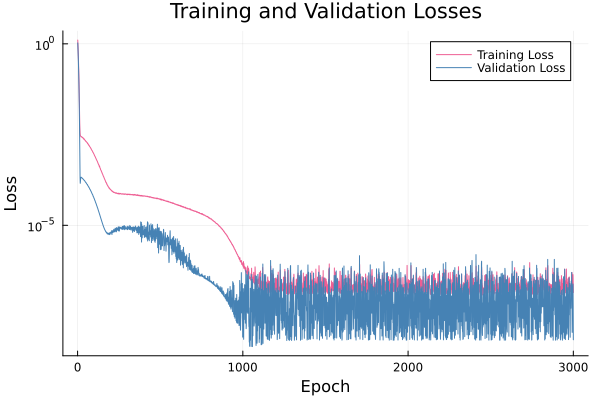

In [10]:
# Plot training and validation loss curves
p = plot(train_losses,label = "Training Loss",xlabel = "Epoch",ylabel = "Loss",title = "Training and Validation Losses", yscale = :log10, color=cur_colors[7])
plot!(val_losses,label = "Validation Loss",yscale = :log10,color=:steelblue)
savefig(joinpath(results_dir, "input_correction_loss.png"))
display(p)

#### Correction Testing

In [11]:
# Roll out the corrected surrogate model over multiple time steps
function unroll_corrected(trained_model, corrective_model, x0, n_steps; input_bias=0.8)
    # Initial condition: x0 reshape to (n_points, 1, 1)
    x = reshape(x0, size(x0,1), 1, 1)  
    
    # Allocate output array to store the full trajectory (initial + n_steps)
    outputs = zeros(eltype(x0), size(x0, 1), 1, n_steps + 1)
    outputs[:, :, 1] .= x0   # store initial condition at t = 0
    
    # Time-stepping loop
    for t in 1:n_steps
        # Apply systematic bias to input 
        x_err = x .* input_bias          
        
        # Forward pass through pretrained surrogate and concatenate data
        y_pre = trained_model(x_err)
        combined_input = vcat(reshape(y_pre, 1, :), reshape(x_err, 1, :))
    
        # Final corrected output 
        y_final = trained_model(reshape(corrective_model(combined_input), size(x_err)))
        outputs[:, :, t + 1] .= y_final

        # Use corrected output as input for next iteration
        x = y_final   
    end

    return outputs
end

unroll_corrected (generic function with 1 method)

In [12]:
# Ensure consistency in rollout length
n_steps = length(burgers_times) - 1   
output_times = burgers_times[1:n_steps+1]
output_x = burgers_data["grid"]

# Initial condition (first snapshot from dataset)
x0 = X[:,:,1]

# Ground-truth trajectory from dataset
Y_true = zeros(Float64, n_points, 1, n_steps+1)
for t in 1:(n_steps+1)
    Y_true[:,1,t] .= burgers_data["solution"][t]
end

# Roll out pretrained surrogate model
Y_pretrained = unroll_pretrained(trained_model, x0, n_steps)

# Roll out corrected surrogate model
Y_corrected  = unroll_corrected(trained_model, corrective_model, x0, n_steps)

nothing


In [13]:
# Calculate accuracy between specific time steps for 3D arrays
function calculate_accuracy(Y_pred, Y_true; tolerance=0.025, initial_step=1, final_step=size(Y_true, 3))
    # Validate input parameters
    if initial_step < 1 || final_step > size(Y_true, 3) || initial_step > final_step
        error("Invalid time step range: initial_step=$initial_step, final_step=$final_step, data length=$(size(Y_true, 3))")
    end
    
    # Extract the specified time step range from the third dimension
    Y_pred_range = Y_pred[:, :, initial_step:final_step]
    Y_true_range = Y_true[:, :, initial_step:final_step]
    
    # Calculate accuracy for the specified range
    correct_predictions = sum((abs.(Y_pred_range .- Y_true_range)) .< tolerance)
    accuracy = (correct_predictions / length(Y_true_range)) * 100
    
    return accuracy
end

calculate_accuracy (generic function with 1 method)

In [14]:
# Calculate accuracy for both pretrained and corrected models for complete trajectory
accuracy_pretrained_full = calculate_accuracy(Y_pretrained, Y_true)
accuracy_corrected_full = calculate_accuracy(Y_corrected, Y_true)

println("Pretrained Model Accuracy: $(round(accuracy_pretrained_full, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_full, digits=2))%")
println("Accuracy Improvement in Full model: $(round((accuracy_corrected_full - accuracy_pretrained_full), digits=2))%")

Pretrained Model Accuracy: 69.32%
Corrected Model Accuracy: 83.16%
Accuracy Improvement in Full model: 13.84%


In [15]:
# Calculate accuracy for both pretrained and corrected models at specific early time range
accuracy_pretrained_range = calculate_accuracy(Y_pretrained, Y_true, initial_step=50, final_step=150)
accuracy_corrected_range = calculate_accuracy(Y_corrected, Y_true, initial_step=50, final_step=150)

println("\nTime Steps 50-150 Results:")
println("Pretrained Model Accuracy: $(round(accuracy_pretrained_range, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_range, digits=2))%")
println("Accuracy Improvement in Range: $(round((accuracy_corrected_range - accuracy_pretrained_range), digits=2))%")

# Calculate accuracy for both pretrained and corrected models at specific late time range
accuracy_pretrained_range2 = calculate_accuracy(Y_pretrained, Y_true, initial_step=250)
accuracy_corrected_range2 = calculate_accuracy(Y_corrected, Y_true, initial_step=250)

println("\nTime Steps 250-End Results:")
println("Pretrained Model Accuracy: $(round(accuracy_pretrained_range2, digits=2))%")
println("Corrected Model Accuracy: $(round(accuracy_corrected_range2, digits=2))%")
println("Accuracy Improvement in Range: $(round((accuracy_corrected_range2 - accuracy_pretrained_range2), digits=2))%")



Time Steps 50-150 Results:
Pretrained Model Accuracy: 91.7%
Corrected Model Accuracy: 73.52%
Accuracy Improvement in Range: -18.18%

Time Steps 250-End Results:
Pretrained Model Accuracy: 63.32%
Corrected Model Accuracy: 86.31%
Accuracy Improvement in Range: 22.99%


In [16]:
function field_metrics(Y_pred, Y_true; eps=1e-8)
    # Difference field
    difference = Y_pred .- Y_true

    # Per-time RMSE and Linf
    rmse_t = sqrt.(mean(abs2, difference; dims=(1,2)))
    linf_t = maximum(abs.(difference); dims=(1,2))

    # Global RMSE and normalized RMSE
    rmse_global = sqrt(mean(abs2.(difference)))
    nrmse_global = rmse_global / (std(Y_true) + eps)

    # Percent within relative tolerance 
    rel_err = abs.(difference) ./ (abs.(Y_true) .+ eps)
    within_5pct = 100 * sum(rel_err .< 0.05) / length(Y_true)

    #C oefficient of determination
    ss_res = sum(abs2.(difference))
    ss_tot = sum(abs2.(Y_true .- mean(Y_true)))
    r2_score = 1.0 - ss_res / (ss_tot + eps)

    return Dict(
    "rmse_t" => vec(rmse_t),
    "linf_t" => vec(linf_t),
    "rmse_global" => rmse_global,
    "nrmse_global" => nrmse_global,
    "pct_within_5pct" => within_5pct, 
    "r2_score" => r2_score
    )
end

field_metrics (generic function with 1 method)

Pre-Trained Results: Global RMSE: 0.03441119383280477 | Normalized RMSE: 0.3087325688926965 
                                   | Percentage within tolerance: 84.27272727272727 | R2 Score: 0.9046832315870033
Corrected Results: Global RMSE: 0.021568255469593484 | Normalized RMSE: 0.19350746591400095 
                                   | Percentage within tolerance: 97.07692307692308 | R2 Score: 0.9625544798356671


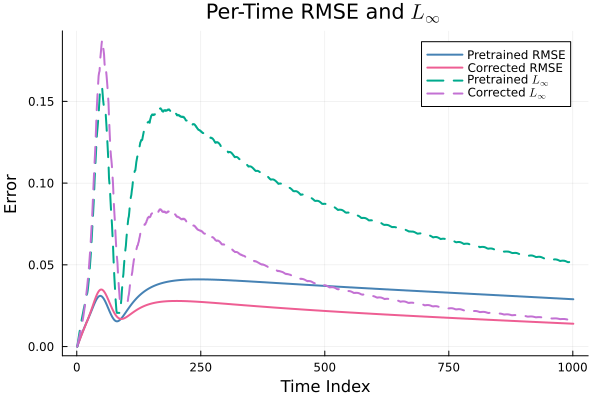

In [17]:
pretrained_metrics = field_metrics(Y_pretrained, Y_true)
corrected_metrics = field_metrics(Y_corrected, Y_true)

println("Pre-Trained Results: Global RMSE: $(pretrained_metrics["rmse_global"]) | Normalized RMSE: $(pretrained_metrics["nrmse_global"]) \n",
        "                                   | Percentage within tolerance: $(pretrained_metrics["pct_within_5pct"]) | R2 Score: $(pretrained_metrics["r2_score"])")
println("Corrected Results: Global RMSE: $(corrected_metrics["rmse_global"]) | Normalized RMSE: $(corrected_metrics["nrmse_global"]) \n",
        "                                   | Percentage within tolerance: $(corrected_metrics["pct_within_5pct"]) | R2 Score: $(corrected_metrics["r2_score"])")

p = plot(pretrained_metrics["rmse_t"], title=L"Per-Time RMSE and $L_{\infty}$", xlabel="Time Index", ylabel="Error", legend=true, linewidth=2, color=:steelblue, label="Pretrained RMSE")
plot!(corrected_metrics["rmse_t"], linewidth=2, color=cur_colors[7], label="Corrected RMSE", linestyle=:solid)
plot!(pretrained_metrics["linf_t"], linewidth=2, color=cur_colors[9], label=L"Pretrained $L_{\infty}$", linestyle=:dash)
plot!(corrected_metrics["linf_t"], linewidth=2, color=cur_colors[4], label=L"Corrected $L_{\infty}$", linestyle=:dash)

savefig(joinpath(results_dir, "input_correction_pertimeRMSE.png"))
display(p)

#### Visual Comparison

In [18]:
function plot_frame(n; save=nothing)
    # Plot a single frame comparing true, pretrained, and corrected solutions
    p = plot(output_x, Y_true[:,1,n], label="Target u(t=$(round(output_times[n], digits=2)))", xlabel="x", ylabel="u", 
         ylim=(0,2), lw=1.5)
    plot!(output_x, Y_pretrained[:,1,n], label="Pretrained u", linestyle=:dash, lw=1.5)
    plot!(output_x, Y_corrected[:,1,n], label="Corrected u", linestyle=:dot, lw=1.5)
    plot!(size=(800,400), title="1D Burgers Equation: True vs Pretrained vs Corrected")

    if save !== nothing
        savefig(save)
    end
    display(p)
end

plot_frame (generic function with 1 method)

In [19]:
function plot_point_time_series(point_index; save=nothing)
    # Plot time series at a specific spatial point comparing true, pretrained, and corrected solutions
    p = plot(output_times, Y_true[point_index, 1, :], label="Target u(x=$(round(output_x[point_index], digits=2)), t)", xlabel="Time", ylabel="u", lw=1.5)
    plot!(output_times, Y_pretrained[point_index, 1, :], label="Pretrained u", linestyle=:dash, lw=1.5)
    plot!(output_times, Y_corrected[point_index, 1, :], label="Corrected u", linestyle=:dot, lw=1.5)
    plot!(size=(800,400), title="Time Series at x = $(round(output_x[point_index], digits=2))")
    
    if save !== nothing
        savefig(save)
    end
    return p
end

plot_point_time_series (generic function with 1 method)

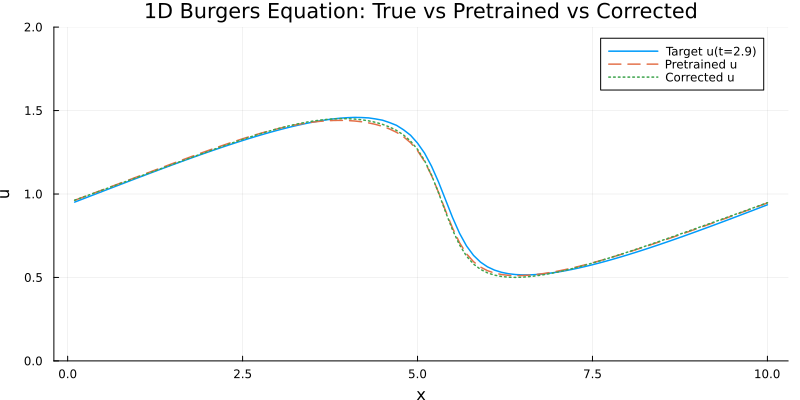

In [20]:
plot_frame(30, save=joinpath(results_dir, "input_correction_frame_30.png"))

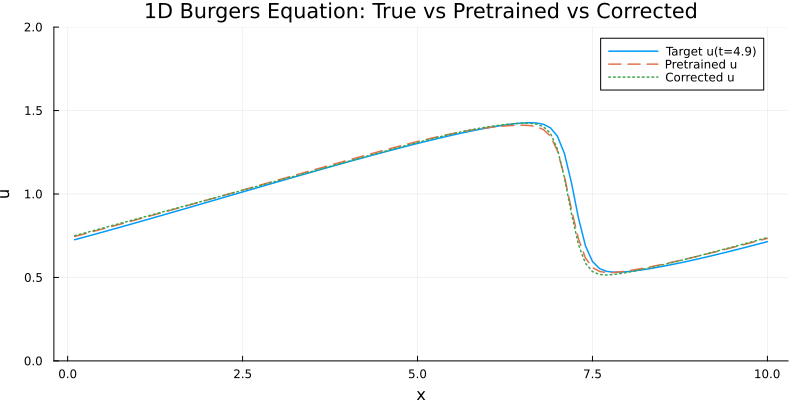

In [21]:
plot_frame(50, save=joinpath(results_dir, "input_correction_frame_50.png"))

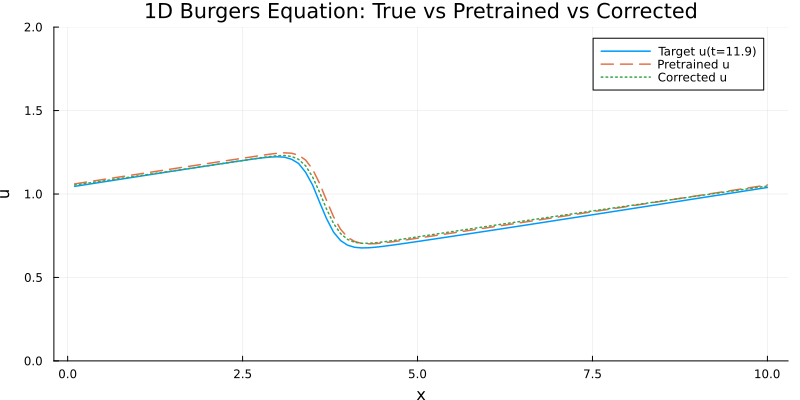

In [22]:
plot_frame(120, save=joinpath(results_dir, "input_correction_frame_120.png"))

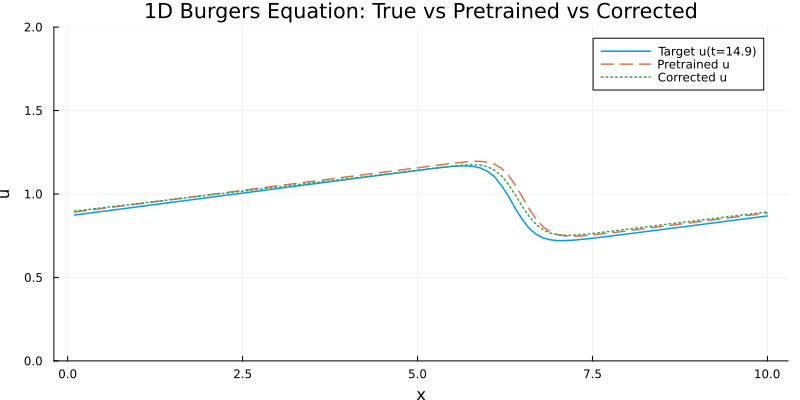

In [23]:
plot_frame(150, save=joinpath(results_dir, "input_correction_frame_150.png"))

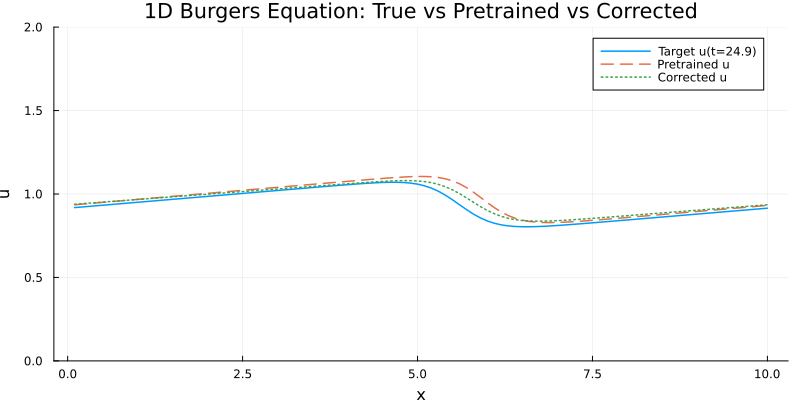

In [24]:
plot_frame(250, save=joinpath(results_dir, "input_correction_frame_250.png"))

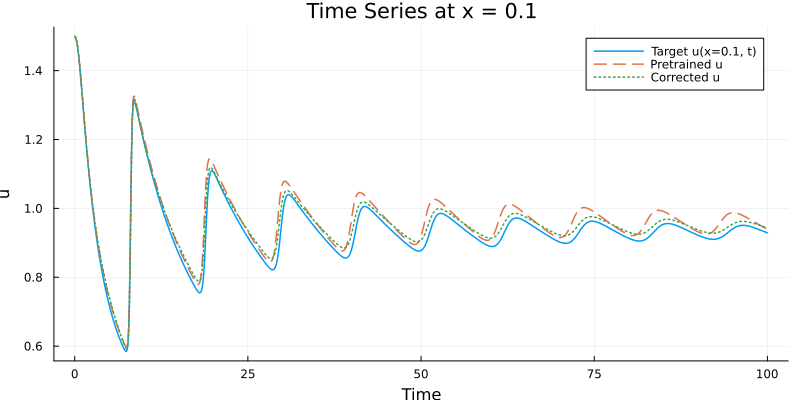

In [25]:
plot_point_time_series(1, save=joinpath(results_dir, "input_correction_time_series_1.png"))


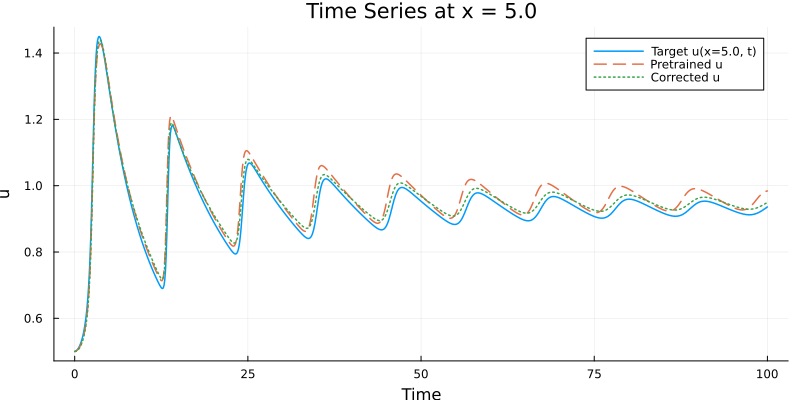

In [26]:
plot_point_time_series(50, save=joinpath(results_dir, "input_correction_time_series_50.png"))


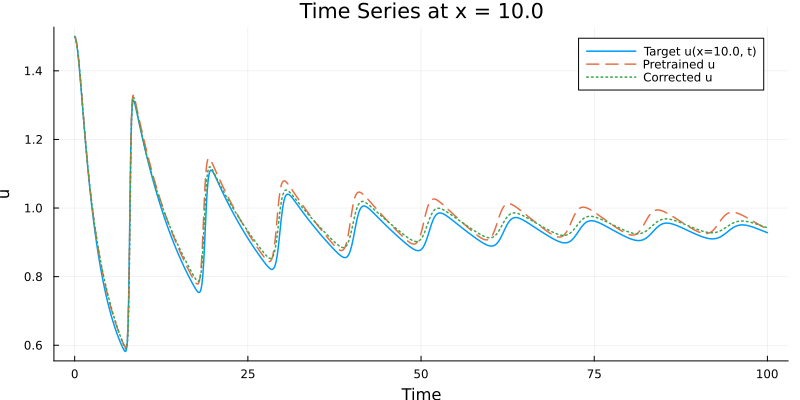

In [27]:
plot_point_time_series(n_points, save=joinpath(results_dir, "input_correction_time_series_$n_points.png"))

┌ Info: Saved animation to /Users/sara/Desktop/Deltares/Final Report Code/Model-1/input_correction/img/input_correction_gif.gif
└ @ Plots /Users/sara/.julia/packages/Plots/8ZnR3/src/animation.jl:156


 26.333452 seconds (13.63 M allocations: 568.911 MiB, 1.81% gc time, 1.66% compilation time: 16% of which was recompilation)


Plots.AnimatedGif("/Users/sara/Desktop/Deltares/Final Report Code/Model-1/input_correction/img/input_correction_gif.gif")
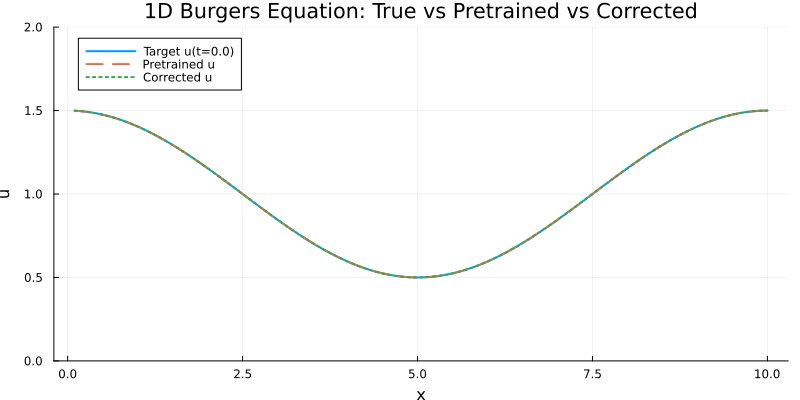

In [28]:
@time begin
    anim = @animate for i in 1:length(output_times)
        p = plot(output_x, Y_true[:,1,i], label="Target u(t=$(round(output_times[i], digits=2)))", xlabel="x", ylabel="u", ylim=(0,2), lw=2)
        plot!(output_x, Y_pretrained[:,1,i], label="Pretrained u", linestyle=:dash, lw=2)
        plot!(output_x, Y_corrected[:,1,i], label="Corrected u", linestyle=:dot, lw=2)
        plot!(p, size=(800,400), title="1D Burgers Equation: True vs Pretrained vs Corrected")
    end
    gif(anim, joinpath(results_dir, "input_correction_gif.gif"), fps=15)
end

#### Save Correction Model

In [29]:
BSON.@save "input_correction.bson" model=corrective_model